# PyRoll Basic Usage Notebook

This Notebook explains the basic usage of PyRoll and serves accordingly as a basic user interface aside the command line interface.
The usage of the command line interface is not described here, since the library is used directly from Python code.
The notebook uses aside the core library several basic plugins, so the provided configuration should be suitable for a first estimation of a rolling process.

## Initialization and Configuration

Import the core library and a bunch of plugins.

In [1]:
import pyroll.basic as pr

Import additional libraries and make some basic configuration.

In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as w
import logging
import sys
import IPython.display as d

logging.basicConfig(stream=sys.stdout, format='[%(levelname)s] %(name)s: %(message)s')
logging.getLogger("pyroll").setLevel(logging.INFO)

## Definition of Initial Workpiece (Profile)

With the following class constructor on defines the state of the workpiece that is fed into the first unit of the rolling sequence.
It holds geometrical values as well as material data.

The example case is a square-shaped profile that can originate for example from a continuous casting plant or from another rolling line.
The `box`-constructor of `Profile` is used, because it allows the dimensioning by width and height, whereas `Profile.square` allows for dimensioning by the length of the diagonal.

In [3]:
in_profile = pr.Profile.square(
    side=45e-3,
    corner_radius=3e-3,
    temperature=1100 + 273.15,
    strain=0,
    material="C45",
    density=7.5e3,
    thermal_capacity=690,
)

Lets plot the profile:

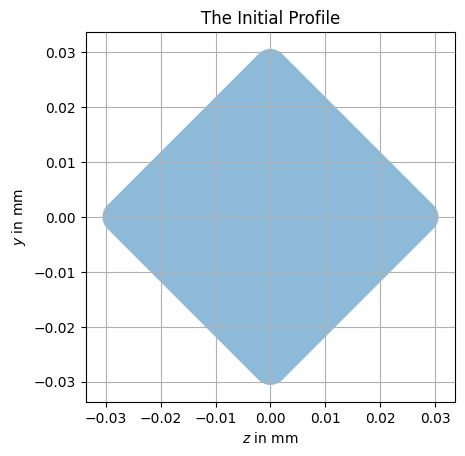

In [4]:
fig: plt.Figure = plt.figure()
ax: plt.Axes = fig.add_subplot()

ax.set_title(r"The Initial Profile")
ax.set_xlabel(r"$z$ in $\mathrm{mm}$")
ax.set_ylabel(r"$y$ in $\mathrm{mm}$")
ax.grid(True)
ax.set_aspect("equal")

ax.fill(*in_profile.cross_section.exterior.xy, alpha=0.5)
plt.show()

## Flow Stress Curve

Additionally, a flow stress model is needed for determining forces and torques.
The Freiberg Flow Stress Model calculates the flow stress according to the following function:

$$
k_\mathrm{f} \left( \varphi, \dot{\varphi}, \vartheta \right) = A\exp\left(m_1 \vartheta\right) \vartheta^{m_9}
\varphi^{m_2} \exp\left( \frac{m_4}{\varphi} \right)
\left(1 + \varphi \right)^{m_5\vartheta+m_6} \exp\left(m_7 \varphi\right)
\dot{\varphi}^{m_3 + m_8 \vartheta}
$$

The model coefficients are defined with the following object:

In [5]:
from pyroll.freiberg_flow_stress import FreibergFlowStressCoefficients, flow_stress

freiberg_flow_stress_coefficients = FreibergFlowStressCoefficients(
    a=3268.49 * 1e6,
    m1=-0.00267855,
    m2=0.34446,
    m4=0.000551814,
    m5=-0.00132042,
    m7=0.0166334,
    m8=0.000149907,
    baseStrain=0.1,
    baseStrainRate=0.1
)

in_profile.freiberg_flow_stress_coefficients = freiberg_flow_stress_coefficients

The flow curve shows up like that:

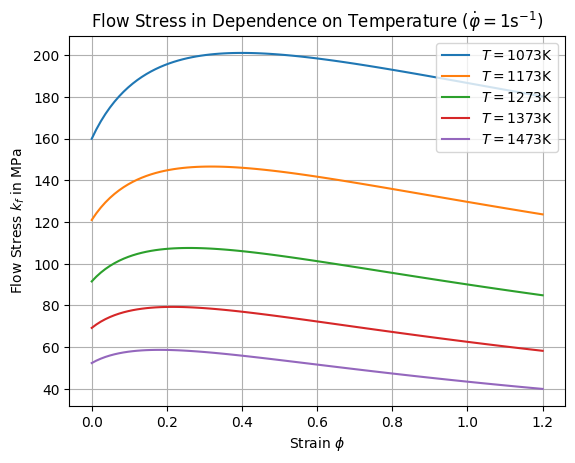

In [6]:
fig: plt.Figure = plt.figure()
ax: plt.Axes = fig.add_subplot()

ax.set_title(r"Flow Stress in Dependence on Temperature ($\dot{\varphi} = 1 \mathrm{s}^{-1}$)")
ax.set_xlabel("Strain $\phi$")
ax.set_ylabel("Flow Stress $k_f$ in MPa")
ax.grid(True)

strains = np.linspace(0, 1.2, 100)

for temp in [1073, 1173, 1273, 1373, 1473]:
    ax.plot(strains, flow_stress(freiberg_flow_stress_coefficients, strains, 1, temp) / 1e6,
            label=rf"$T = {temp} \mathrm{{K}}$")

ax.legend()

plt.show()

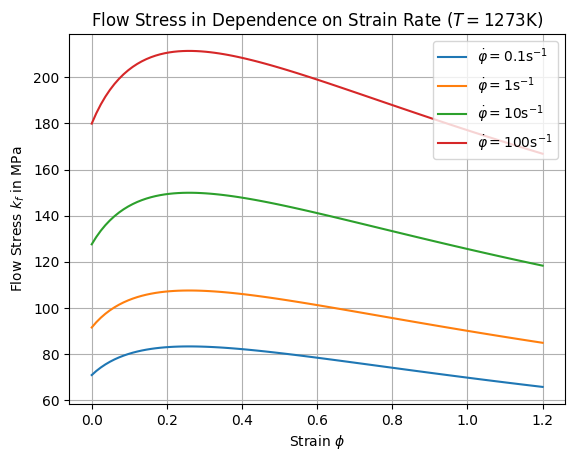

In [7]:
fig: plt.Figure = plt.figure()
ax: plt.Axes = fig.add_subplot()

ax.set_title(r"Flow Stress in Dependence on Strain Rate ($T = 1273 \mathrm{K}$)")
ax.set_xlabel("Strain $\phi$")
ax.set_ylabel("Flow Stress $k_f$ in MPa")
ax.grid(True)

strains = np.linspace(0, 1.2, 100)

for rate in [0.1, 1, 10, 100]:
    ax.plot(strains, flow_stress(freiberg_flow_stress_coefficients, strains, rate, 1273) / 1e6,
            label=rf"$\dot{{\varphi}} = {rate} \mathrm{{s}}^{{-1}}$")

ax.legend()

plt.show()

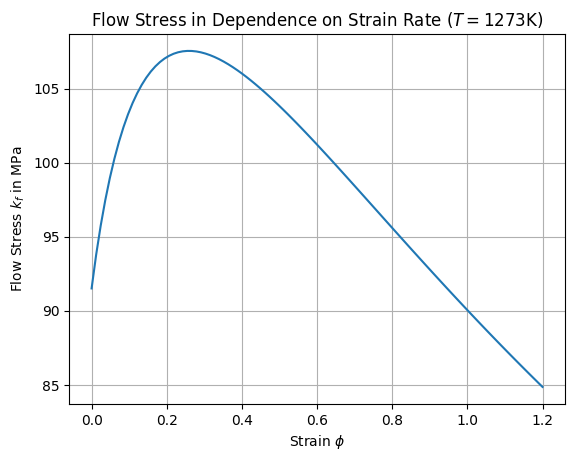

interactive(children=(FloatLogSlider(value=1.0, description='strain_rate', max=2.0, min=-1.0), IntSlider(value…

In [8]:
fig: plt.Figure = plt.figure()
ax: plt.Axes = fig.add_subplot()

plt.ioff()

ax.set_title(r"Flow Stress in Dependence on Strain Rate ($T = 1273 \mathrm{K}$)")
ax.set_xlabel("Strain $\phi$")
ax.set_ylabel("Flow Stress $k_f$ in MPa")
ax.grid(True)

strains = np.linspace(0, 1.2, 100)
line = ax.plot(strains, flow_stress(freiberg_flow_stress_coefficients, strains, 1, 1273) / 1e6)[0]


@w.interact(
    temperature=(1073, 1473, 10),
    strain_rate=w.FloatLogSlider(min=-1, max=2, base=10)
)
def interactive_flow_stress_plot(strain_rate, temperature):
    data = flow_stress(freiberg_flow_stress_coefficients, strains, strain_rate, temperature) / 1e6
    line.set_ydata(data)
    upper = np.max(data) * 1.2
    if upper > ax.get_ylim()[1]:
        ax.set_ylim(0, upper)
    fig.canvas.draw()


plt.show()

## The Pass Sequence

The sequence of roll passes and transport ranges is defined by a list of units.
The sequence shown here represents an experimental plant at the Institute of Metals Forming of the TU Bergakademie Freiberg.
The plant uses three 3-high rolling stands with slightly different diameters of each roll.
However, PyRoll is currently only able to simulate symmetrical passes, so the average diameter is used here.

In [9]:
mean_roll_radius_1_upper = (328e-3 + 324e-3) / 2 / 2
mean_roll_radius_1_lower = (324e-3 + 320e-3) / 2 / 2
mean_roll_radius_2_upper = (299e-3 + 297e-3) / 2 / 2
mean_roll_radius_2_lower = (297e-3 + 295e-3) / 2 / 2
mean_roll_radius_3_upper = (280e-3 + 278e-3) / 2 / 2
mean_roll_radius_3_lower = (278e-3 + 276e-3) / 2 / 2

Since the workpiece is fed into the next pass by hand, an average transport time is assumed between the passes, in which the workpiece is cooling down a bit.

In [10]:
transport_duration = 2

The following cell defines the sequence.
The sequence starts with a few Square-Diamond passes and continues with Square-Oval passes.
The passes are enumerated by roman numbers and labeled with their type. This is just for human identification in display and has no further technical use in PyRoll.

In [11]:
sequence = pr.PassSequence([
    pr.RollPass(
        label="Raute I",
        roll=pr.Roll(
            groove=pr.DiamondGroove(
                usable_width=76.55e-3,
                tip_depth=22.1e-3,
                r1=12e-3,
                r2=8e-3
            ),
            nominal_radius=mean_roll_radius_1_lower,
            poissons_ratio=0.3,
            elastic_modulus=210e9
        ),
        velocity=1,
        gap=3e-3,
    ),
    pr.Transport(
        duration=transport_duration
    ),
    pr.RollPass(
        label="Quadrat II",
        roll=pr.Roll(
            groove=pr.SquareGroove(
                usable_width=52.7e-3,
                tip_depth=25.95e-3,
                r1=8e-3,
                r2=6e-3
            ),
            nominal_radius=mean_roll_radius_1_upper,
            poissons_ratio=0.3,
            elastic_modulus=210e9
        ),
        velocity=1,
        gap=3e-3,
    ),
    pr.Transport(
        duration=transport_duration
    ),
    pr.RollPass(
        label="Raute III",
        roll=pr.Roll(
            groove=pr.DiamondGroove(
                usable_width=58.3e-3,
                tip_depth=16.85e-3,
                r1=7e-3,
                r2=8e-3
            ),
            nominal_radius=mean_roll_radius_1_lower,
            poissons_ratio=0.3,
            elastic_modulus=210e9
        ),
        velocity=1,
        gap=3e-3,
    ),
    pr.Transport(
        duration=transport_duration
    ),
    pr.RollPass(
        label="Quadrat IV",
        roll=pr.Roll(
            groove=pr.SquareGroove(
                usable_width=40.74e-3,
                tip_depth=20.05e-3,
                r1=7e-3,
                r2=5e-3
            ),
            nominal_radius=mean_roll_radius_1_upper,
            poissons_ratio=0.3,
            elastic_modulus=210e9
        ),
        velocity=1,
        gap=3e-3,
    ),
    pr.Transport(
        duration=transport_duration
    ),
    pr.RollPass(
        label="Oval V",
        roll=pr.Roll(
            groove=pr.CircularOvalGroove(
                depth=7.25e-3,
                r1=6e-3,
                r2=44.5e-3
            ),
            nominal_radius=mean_roll_radius_1_lower,
            poissons_ratio=0.3,
            elastic_modulus=210e9
        ),
        velocity=1,
        gap=3e-3,
    ),
    pr.Transport(
        duration=transport_duration
    ),
    pr.RollPass(
        label="Quadrat VI",
        roll=pr.Roll(
            groove=pr.SquareGroove(
                usable_width=29.64e-3,
                tip_depth=14.625e-3,
                r1=6e-3,
                r2=4e-3
            ),
            nominal_radius=mean_roll_radius_1_upper,
            poissons_ratio=0.3,
            elastic_modulus=210e9
        ),
        velocity=1,
        gap=3e-3,
    ),
    pr.Transport(
        duration=transport_duration
    ),
    pr.RollPass(
        label="Oval VII",
        roll=pr.Roll(
            groove=pr.CircularOvalGroove(
                depth=5.05e-3,
                r1=7e-3,
                r2=33e-3
            ),
            nominal_radius=mean_roll_radius_1_lower,
            poissons_ratio=0.3,
            elastic_modulus=210e9
        ),
        velocity=1,
        gap=3e-3,
    ),
    pr.Transport(
        duration=transport_duration
    ),
    pr.RollPass(
        label="Quadrat VIII",
        roll=pr.Roll(
            groove=pr.SquareGroove(
                usable_width=21.54e-3,
                tip_depth=10.6e-3,
                r1=5e-3,
                r2=3e-3
            ),
            nominal_radius=mean_roll_radius_1_upper,
            poissons_ratio=0.3,
            elastic_modulus=210e9
        ),
        velocity=1,
        gap=3e-3,
    ),
    pr.Transport(
        duration=transport_duration
    ),
    pr.RollPass(
        label="Oval IX",
        roll=pr.Roll(
            groove=pr.CircularOvalGroove(
                depth=4.43e-3,
                r1=6e-3,
                r2=25.5e-3
            ),
            nominal_radius=mean_roll_radius_2_lower,
            poissons_ratio=0.3,
            elastic_modulus=210e9
        ),
        velocity=1,
        gap=1e-3,
    ),
    pr.Transport(
        duration=transport_duration
    ),
    pr.RollPass(
        label="Fertigrund Xa",
        roll=pr.Roll(
            groove=pr.RoundGroove(
                r1=2e-3,
                r2=15.8e-3 / 2,
                depth=7.65e-3
            ),
            nominal_radius=mean_roll_radius_2_upper,
            poissons_ratio=0.3,
            elastic_modulus=210e9
        ),
        velocity=1,
        gap=0.5e-3,
    ),
])

## Running the Solution Algorithm

Once we defined the initial profile and the sequence, the `solve()` method is used to fire the simulation algorithm.

In [12]:
sequence.solve(in_profile)

[INFO] pyroll.core.PassSequence: Started solving of PassSequence.
[INFO] pyroll.core.RollPass: Started solving of RollPass 'Raute I'.
[INFO] pyroll.core.Rotator: Started solving of Rotator 'Auto-Rotator for RollPass 'Raute I''.
[INFO] pyroll.core.Rotator: Finished solving of Rotator 'Auto-Rotator for RollPass 'Raute I'' after 2 iterations.
[INFO] pyroll.core.Rotator: Solution took 0.003 s.
[INFO] pyroll.core.RollPass: Finished solving of RollPass 'Raute I' after 7 iterations.
[INFO] pyroll.core.RollPass: Solution took 0.066 s.
[INFO] pyroll.core.Transport: Started solving of Transport.
[INFO] pyroll.core.Transport: Finished solving of Transport after 2 iterations.
[INFO] pyroll.core.Transport: Solution took 0.003 s.
[INFO] pyroll.core.RollPass: Started solving of RollPass 'Quadrat II'.
[INFO] pyroll.core.Rotator: Started solving of Rotator 'Auto-Rotator for RollPass 'Quadrat II''.
[INFO] pyroll.core.Rotator: Finished solving of Rotator 'Auto-Rotator for RollPass 'Quadrat II'' after 2 i

Profile(
    classifiers={'generic_elongation', 'round'},
    cross_section=Polygon(
        area=0.00017570071551876,
        height=0.015799999999999998,
        perimeter=0.048257316921936036,
        width=0.012651404537658997,
        ),
    density=7500.0,
    freiberg_flow_stress_coefficients=FreibergFlowStressCoefficients(a=3268490000.0, m1=-0.00267855, m2=0.34446, m3=0, m4=0.000551814, m5=-0.00132042, m6=0, m7=0.0166334, m8=0.000149907, m9=0, baseStrain=0.1, baseStrainRate=0.1),
    length=0.0,
    material='C45',
    strain=0.3520273306345031,
    t=18.435109033688455,
    temperature=1345.349476591933,
    thermal_capacity=690,
    )

## Analysing the results

To generate the report page that can also be obtained from the CLI command `report`, one may use the respective class directly.

In [13]:
from pyroll.report import report

rendered = report(sequence)
file = "report.html"
file_path = pathlib.Path.cwd() / file
file_path.write_text(rendered, encoding='utf-8')

1769149